<h1 align="center">
        <picture>
         <source media="(prefers-color-scheme: dark)" srcset="https://user-images.githubusercontent.com/16140783/218357099-29d4848f-89ee-463e-9ead-40f27c976f61.png">
         <img width="300" src="https://user-images.githubusercontent.com/16140783/218437368-1aa8506c-1ed8-460a-99de-d2c081557170.png" align="center"></img>
    </picture><br/><br/>Subvocalization EMG - PoC<sub><sup><br/>(Public data)</sup></sub>
</h1>

This PoC is using the same technique in the Complete processing PoC, but using public EMG data instead of Synthetic data. The dataset (and its research) used in this ipynb can be found at https://zenodo.org/record/7668251.



### Packages


In [1]:
from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from more_itertools import sliced
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, os.path
import np_utils
import random

### Reading raw EMG data

The sEMG data of the subjects downloaded from Zenodo should be extracted to a folder named `dataset`. We will then parse it and change its structure to match the CSV generated by the subvocalization software.

In [2]:
path = "./dataset"
data = [name for name in os.walk(path)]
gestures = ["Open hand", "Closed hand", "Lateral pinch", "Signaling sign", "Rock sign"]
dataframes = [[],[],[],[],[]]

emg_channels = [1, 2, 3, 4]
df_channels = list(map(lambda x: "Channel_%s" % (x), emg_channels))

for i in range(1,len(data)):
    for j in range(0,len(data[i][2])):
        file_name = data[i][2][j]
        gesture = int(os.path.splitext(file_name)[0])
        dataframe = pd.read_csv(data[i][0] + '/' + data[i][2][j], sep='\t', header=None, names=df_channels)
        dataframes[gesture].append(dataframe)

This completes the importing stage, now all subjects' datasets are stored in their respectively gesture slot. We can render the channels from a single subject just like in the Complete processing PoC using data from the Cyton Board:

[1, 2, 3, 4]
['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4']

Plot channels:


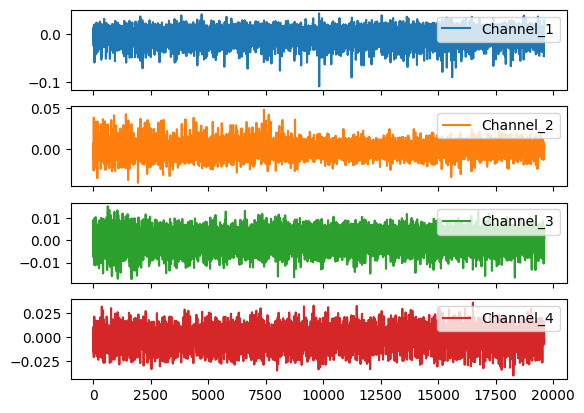

In [3]:
random_subject_open_hand = random.choice(dataframes[0])

print(emg_channels)
print(df_channels)
print("\nPlot channels:")

axs = random_subject_open_hand[df_channels].plot(subplots=True)
for i,ax in enumerate(axs):
    axs[i].legend(loc="upper right")

plt.show()

However, this dataset has the whole recording in a single stream, therefore we need to break it into intervals. The authors state this dataset has a window length of 200:


Plot channels:


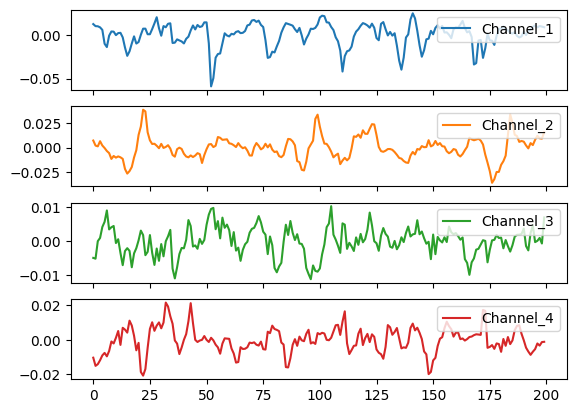

In [4]:
window_length = 200

chunk = next(sliced(random_subject_open_hand, window_length))

print("\nPlot channels:")
axs = chunk[df_channels].plot(subplots=True)
for i,ax in enumerate(axs):
    axs[i].legend(loc="upper right")

plt.show()

Lastly, we need to parse this data to make it as similar as our dataset, adding the word (gesture) in the first column. In this step we perform the segmentation and merge it all into a single dataset:

In [5]:
subjects_count = len(data) - 1
restored_data = pd.DataFrame(columns=['WORD'] + df_channels)
min_attr = float('inf')
for gesture_frames in dataframes:
    for df in gesture_frames:
        min_attr = min(min_attr, len(df))
rows = range(min_attr)

# Iterate subjects
for k in range(subjects_count):
    # Iterate window (segmentation)
    for index_slice in sliced(rows, window_length):
        # Iterate gestures
        for g in range(len(gestures)):
            df = dataframes[g][k]
            df['WORD'] = gestures[g]
            chunk = df.iloc[index_slice]
            restored_data = pd.concat([restored_data, chunk], ignore_index = True)

restored_data

,WORD,Channel_1,Channel_2,Channel_3,Channel_4
0,Open hand,0.004898,0.004003,-0.004031,-0.001103
1,Open hand,0.003446,-0.004977,0.001012,-0.002247
2,Open hand,-0.003934,-0.009833,0.007323,-0.003097
3,Open hand,-0.002250,-0.007743,-0.004610,-0.000540
4,Open hand,-0.003268,-0.006243,0.002576,-0.003321
...,...,...,...,...,...
759555,Rock sign,0.034819,-0.008418,-0.006649,0.027904
759556,Rock sign,0.043744,-0.007028,-0.001524,0.050832
759557,Rock sign,0.055965,-0.002811,0.007052,0.015889
759558,Rock sign,0.054340,-0.014413,-0.030651,-0.001178


### Preprocessing

With our 4 channels data in hand, we can perform a Butterworth filter to select the frequency range we want to keep, here we want a lowcut of 3.0 and a highcut of 45.0:

In [6]:
sampling_rate = window_length
exg_channels = [1, 2, 3, 4]

curves = [[], [], [], []]
for count, channel in enumerate(df_channels):
    if count >= 8:
        continue
    channel_data = restored_data[channel].to_numpy()
    DataFilter.detrend(channel_data, DetrendOperations.CONSTANT.value)
    DataFilter.perform_bandpass(channel_data, sampling_rate, 3.0, 45.0, 2,
                                FilterTypes.BUTTERWORTH.value, 0)
    DataFilter.perform_bandstop(channel_data, sampling_rate, 48.0, 52.0, 2,
                                FilterTypes.BUTTERWORTH.value, 0)
    DataFilter.perform_bandstop(channel_data, sampling_rate, 58.0, 62.0, 2,
                                FilterTypes.BUTTERWORTH.value, 0)
    curves[count] = channel_data

preprocessed_data = pd.DataFrame(np.transpose(curves))

preprocessed_data

,0,1,2,3
0,0.000914,0.000747,-0.000752,-0.000206
1,0.002628,0.000694,-0.001444,-0.000868
2,0.001910,-0.002834,0.000752,-0.001772
3,-0.001237,-0.006782,0.002450,-0.001909
4,-0.003539,-0.007481,0.001235,-0.001372
...,...,...,...,...
759555,0.040822,-0.001697,-0.022724,0.047444
759556,0.040447,-0.015736,-0.018161,0.021748
759557,0.043213,-0.017485,-0.013564,0.015942
759558,0.047369,-0.009081,-0.020551,0.009154


We can also plot these curves to see the difference between the unprocessed data, note the scales also were reduced since we removed unused information:

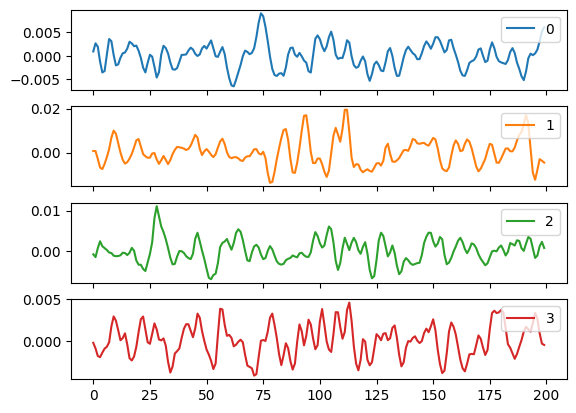

In [7]:
chunk = next(sliced(preprocessed_data, window_length))

axs = chunk.plot(subplots=True)
for i,ax in enumerate(axs):
    axs[i].legend(loc="upper right")

plt.show()

In this session we recorded 6 words with the Synthetic board.
Now that we have all the session preprocessed, we need to split it in six parts. However, some words might be recorded with an average of ± 2 extra samples, therefore, we also need to map all the splits to have the same size:

In [8]:
emg_words = []
emg_data = []
curves = pd.DataFrame(curves)

word = None
data = None
for i in range(len(restored_data)):
    if i == 0:
        word = restored_data.iloc[i, 0]
        data = curves[i]
    elif restored_data.iloc[i, 0] == word:
        data = np.vstack((data, curves[i]))
    else:
        emg_words.append(word)
        emg_data.append(data)
        word = restored_data.iloc[i, 0]
        data = curves[i]

emg_words.append(word)
emg_data.append(data)
# We need all samples to have the same size, so we standardize it to have the lowest size
samples = min([len(x) for x in emg_data])
data_reduced = [x[:samples] for x in emg_data]
emg_data = np.asarray(data_reduced).astype('float32')

print("Lowest sample size: '%d'" % samples)
print("\nEMG data for the first word ('%s'):" % (emg_words[0]))

pd.DataFrame(emg_data[0])

Lowest sample size: '189'

EMG data for the first word ('Open hand'):


,0,1,2,3
0,0.000914,0.000747,-0.000752,-0.000206
1,0.002628,0.000694,-0.001444,-0.000868
2,0.001910,-0.002834,0.000752,-0.001772
3,-0.001237,-0.006782,0.002450,-0.001909
4,-0.003539,-0.007481,0.001235,-0.001372
...,...,...,...,...
184,0.000800,0.000620,0.002009,-0.000793
185,0.001614,0.000603,0.001741,-0.001457
186,0.000584,0.002295,0.001405,-0.002100
187,-0.001439,0.005511,0.002690,-0.001532


### Words visualization

These words are now a 2d array (sample x channel) inside a list of words. Which means all the words could be individually seen as a 2-dimensional image heatmap, knowing the columns represents each channel, and the rows are the data recorded over time:

<Figure size 640x480 with 0 Axes>

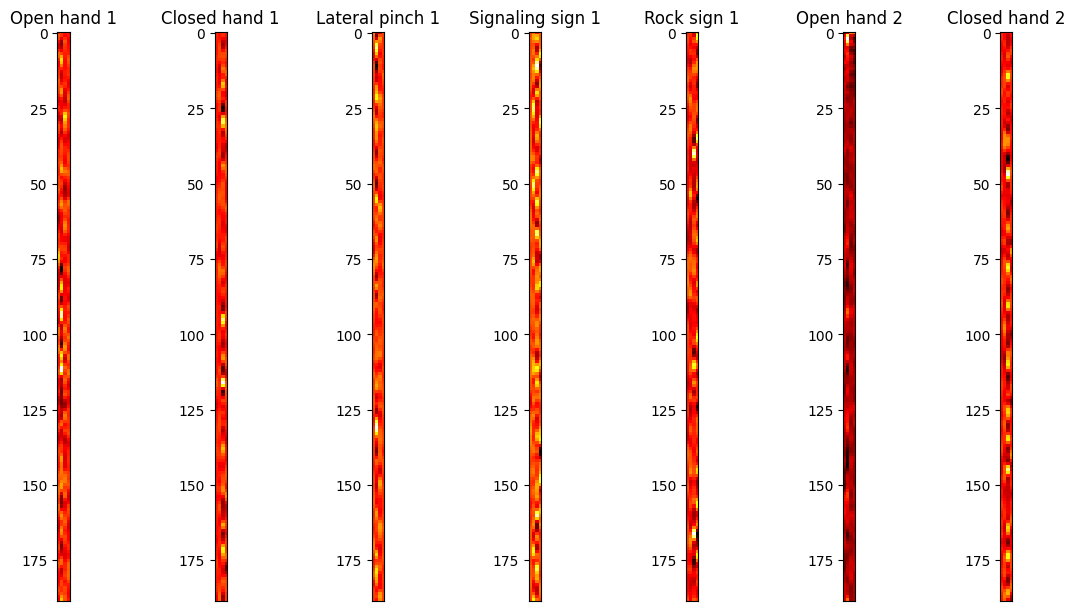

In [9]:
plt.figure()
_f, axarr = plt.subplots(1, 7, constrained_layout=True, figsize=(11, 6))
for i, word in enumerate(emg_words[:7]):
    axarr[i].imshow(emg_data[i], cmap='hot', interpolation='none')
    axarr[i].title.set_text(word + ' %d'% (1 + i/5))
    axarr[i].set(xticks=[])
plt.show()

### Training the Neural Network

We need to factorize the words array so we can get an unique list of the words used, and also retreive a list the model can read as an expected output:

In [10]:
words, words_map = pd.factorize(emg_words)
words = to_categorical(words)
possibilities = len(words_map)
index = list(map(lambda x: "Word %s" % (x), range(1, 7)))

print("This is the expected output, containing only %s possibilities (%s):" % (possibilities, ', '.join(words_map)))

pd.DataFrame(words[:6].astype('int'), columns=words_map, index=index)

This is the expected output, containing only 5 possibilities (Open hand, Closed hand, Lateral pinch, Signaling sign, Rock sign):


,Open hand,Closed hand,Lateral pinch,Signaling sign,Rock sign
Word 1,1,0,0,0,0
Word 2,0,1,0,0,0
Word 3,0,0,1,0,0
Word 4,0,0,0,1,0
Word 5,0,0,0,0,1
Word 6,1,0,0,0,0


Finally, the colormap only has one color, so all we have to do now is to split the words that will be used to train (90%) and the words used to validate (10%) and submit all these "words" into a single dimensional Convolutional Neural Network (CNN) to create our model:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(emg_data, words, test_size=.10)

model = Sequential()
model.add(Conv1D(40, 10, strides=2, padding='same', activation='relu', input_shape=(samples, 4)))
model.add(Dropout(0.2))
model.add(MaxPooling1D(3))
model.add(GlobalAveragePooling1D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(possibilities, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=256, epochs=1000, verbose=1, shuffle=True)

Epoch 1/1000
14/14 [==============================] - 1s 21ms/step - loss: 0.6872 - acc: 0.2058 - val_loss: 0.6793 - val_acc: 0.1711
Epoch 2/1000
14/14 [==============================] - 0s 13ms/step - loss: 0.6686 - acc: 0.2067 - val_loss: 0.6571 - val_acc: 0.1711
Epoch 3/1000
14/14 [==============================] - 0s 12ms/step - loss: 0.6383 - acc: 0.2079 - val_loss: 0.6217 - val_acc: 0.1711
Epoch 4/1000
14/14 [==============================] - 0s 13ms/step - loss: 0.5939 - acc: 0.2129 - val_loss: 0.5731 - val_acc: 0.1711
Epoch 5/1000
14/14 [==============================] - 0s 13ms/step - loss: 0.5443 - acc: 0.2085 - val_loss: 0.5282 - val_acc: 0.1711
Epoch 6/1000
14/14 [==============================] - 0s 14ms/step - loss: 0.5135 - acc: 0.2181 - val_loss: 0.5056 - val_acc: 0.1711
Epoch 7/1000
14/14 [==============================] - 0s 13ms/step - loss: 0.5046 - acc: 0.2345 - val_loss: 0.4974 - val_acc: 0.3842
Epoch 8/1000
14/14 [==============================] - 0s 13ms/step - 

Here's the loss chart using this model:

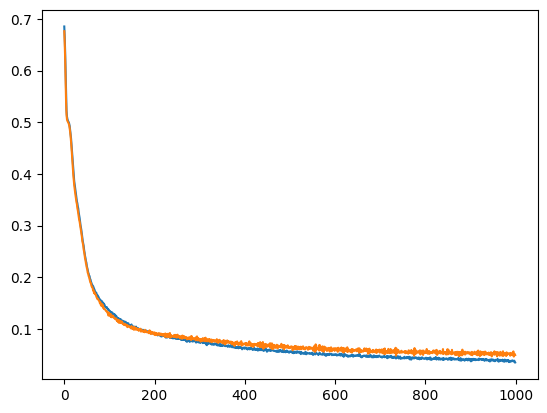

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Now that our model is trained, we can predict single words with a stream of samples gathered from EMG recording:

In [13]:
test_data = emg_data[0].astype('float32')
test_data = np.expand_dims(test_data, axis=0)
prediction_table = model.predict(test_data)

pd.DataFrame(prediction_table, columns=words_map)

1/1 [==============================] - 0s 74ms/step


,Open hand,Closed hand,Lateral pinch,Signaling sign,Rock sign
0,1.0,7.571407e-24,8.682827e-21,2.022934e-20,1.319103e-21


In [14]:
predicted_word_index = np.argmax(prediction_table, axis=1)
predicted_word = pd.DataFrame(words_map).iloc[predicted_word_index].values[0][0]

print("Predicted word: %s" % (predicted_word))

Predicted word: Open hand


When predicting in real time with a classifier stream, to guarantee the predicted word is right, we can also create a history list with the last ~10 predictions or so, and assume the word being subvocalized is the most seen in the history.